# Session 6: HAR Models and Realized Measures

## Course: Advanced Volatility Modeling

---

## Learning Objectives

1. Understand the Heterogeneous Autoregressive (HAR) model
2. Implement HAR-RV and extensions (HAR-RV-J, HAR-RV-CJ)
3. Forecast realized volatility and evaluate forecast performance
4. Work with realized semivariance and signed measures

---

## 1. The HAR Model

### 1.1 Motivation: Heterogeneous Market Hypothesis

Müller et al. (1997) proposed that markets contain agents operating at different time horizons:
- **Daily traders**: react to daily information
- **Weekly traders**: institutional investors, portfolio rebalancing
- **Monthly traders**: long-term investors, pension funds

### 1.2 HAR-RV Model (Corsi, 2009)

$$\boxed{RV_t^{(d)} = \beta_0 + \beta_d RV_{t-1}^{(d)} + \beta_w RV_{t-1}^{(w)} + \beta_m RV_{t-1}^{(m)} + \epsilon_t}$$

where:
- $RV_t^{(d)}$: daily RV
- $RV_t^{(w)} = \frac{1}{5}\sum_{i=1}^{5} RV_{t-i}^{(d)}$: weekly average
- $RV_t^{(m)} = \frac{1}{22}\sum_{i=1}^{22} RV_{t-i}^{(d)}$: monthly average

### 1.3 Key Properties

- Simple linear model (OLS estimation)
- Captures long memory through cascade of components
- Often outperforms GARCH for RV forecasting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

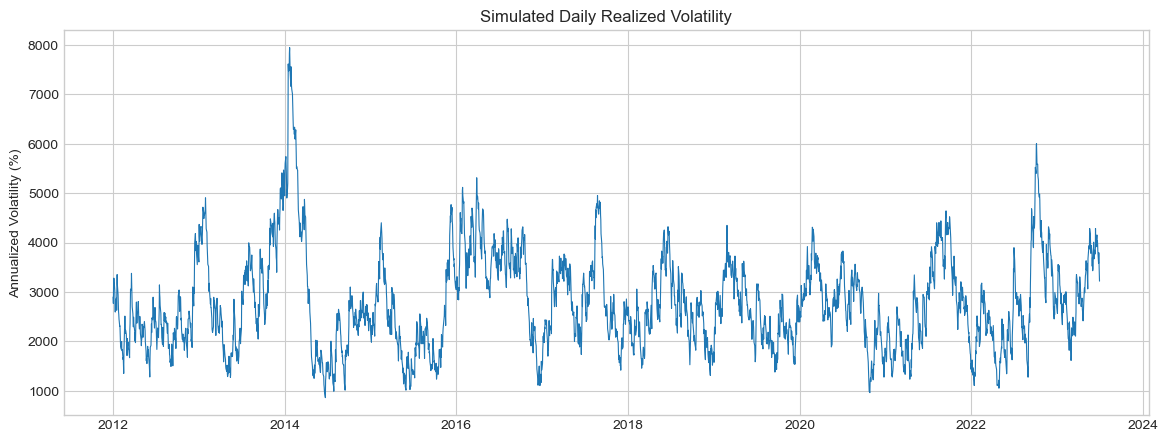

In [3]:
def simulate_rv_series(n_days, omega=0.1, d_coef=0.3, persistence=0.97):
    """Simulate daily RV series with long memory."""
    rv = np.zeros(n_days)
    rv[0] = omega / (1 - persistence)
    
    for t in range(1, n_days):
        shock = np.random.exponential(1) - 1
        rv[t] = omega + persistence * rv[t-1] + d_coef * shock * np.sqrt(rv[t-1])
        rv[t] = max(rv[t], 0.01)
    
    return rv

# Simulate RV series
n_days = 3000
rv_sim = simulate_rv_series(n_days)
dates = pd.date_range('2012-01-01', periods=n_days, freq='B')
rv_series = pd.Series(rv_sim, index=dates, name='RV')

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(rv_series.index, np.sqrt(rv_series) * np.sqrt(252) * 100, linewidth=0.8)
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('Simulated Daily Realized Volatility')
plt.show()

In [4]:
def prepare_har_data(rv, horizon=1):
    """
    Prepare data for HAR model estimation.
    
    Parameters
    ----------
    rv : pd.Series
        Daily realized variance
    horizon : int
        Forecast horizon in days
    
    Returns
    -------
    DataFrame with y and X variables
    """
    df = pd.DataFrame(index=rv.index)
    
    # Target: h-day ahead RV (or average for h>1)
    if horizon == 1:
        df['y'] = rv.shift(-1)
    else:
        df['y'] = rv.rolling(horizon).mean().shift(-horizon)
    
    # Regressors (lagged)
    df['RV_d'] = rv  # Daily
    df['RV_w'] = rv.rolling(5).mean()  # Weekly
    df['RV_m'] = rv.rolling(22).mean()  # Monthly
    
    return df.dropna()

def fit_har(rv, horizon=1):
    """Estimate HAR-RV model."""
    df = prepare_har_data(rv, horizon)
    
    y = df['y']
    X = sm.add_constant(df[['RV_d', 'RV_w', 'RV_m']])
    
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    return model, df

# Fit HAR model
har_model, har_data = fit_har(rv_series, horizon=1)

print("HAR-RV Model Estimation")
print("="*60)
print(har_model.summary().tables[1])

print(f"\nR² = {har_model.rsquared:.4f}")
print(f"Adj. R² = {har_model.rsquared_adj:.4f}")

HAR-RV Model Estimation
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0831      0.025      3.286      0.001       0.034       0.133
RV_d           1.0191      0.036     28.384      0.000       0.949       1.089
RV_w          -0.0500      0.038     -1.316      0.188      -0.124       0.024
RV_m           0.0071      0.013      0.534      0.593      -0.019       0.033

R² = 0.9546
Adj. R² = 0.9546


## 2. HAR Extensions

### 2.1 HAR-RV-J: Adding Jump Component

$$RV_t^{(d)} = \beta_0 + \beta_d RV_{t-1}^{(d)} + \beta_w RV_{t-1}^{(w)} + \beta_m RV_{t-1}^{(m)} + \beta_j J_{t-1} + \epsilon_t$$

where $J_t = \max(RV_t - BV_t, 0)$.

### 2.2 HAR-RV-CJ: Continuous and Jump Components

$$RV_t = \beta_0 + \beta_{cd} C_{t-1}^{(d)} + \beta_{cw} C_{t-1}^{(w)} + \beta_{cm} C_{t-1}^{(m)} + \beta_j J_{t-1} + \epsilon_t$$

where $C_t = BV_t$ (continuous component).

In [6]:
def simulate_rv_with_jumps(n_days, base_vol=0.15, jump_prob=0.05, jump_size=0.5):
    """Simulate RV series with separate continuous and jump components."""
    continuous = np.zeros(n_days)
    jumps = np.zeros(n_days)
    
    continuous[0] = base_vol**2
    
    for t in range(1, n_days):
        # Continuous component (GARCH-like)
        continuous[t] = 0.01 + 0.1 * (continuous[t-1] * np.random.exponential(1)) + 0.85 * continuous[t-1]
        continuous[t] = max(continuous[t], 0.0001)
        
        # Jump component
        if np.random.random() < jump_prob:
            jumps[t] = jump_size * continuous[t] * np.random.exponential(1)
    
    rv = continuous + jumps
    return pd.DataFrame({'RV': rv, 'C': continuous, 'J': jumps})

# Simulate with jumps
n_days = 2500
dates = pd.date_range('2015-01-01', periods=n_days, freq='B')
sim_data = simulate_rv_with_jumps(n_days)
sim_data.index = dates

# Prepare HAR-CJ data
def prepare_har_cj_data(data, horizon=1):
    df = pd.DataFrame(index=data.index)
    
    # Target
    df['y'] = data['RV'].shift(-horizon) if horizon == 1 else data['RV'].rolling(horizon).mean().shift(-horizon)
    
    # Continuous components
    df['C_d'] = data['C']
    df['C_w'] = data['C'].rolling(5).mean()
    df['C_m'] = data['C'].rolling(22).mean()
    
    # Jump component
    df['J_d'] = data['J']
    
    return df.dropna()

har_cj_data = prepare_har_cj_data(sim_data)

# Fit HAR-CJ
y = har_cj_data['y']
X = sm.add_constant(har_cj_data[['C_d', 'C_w', 'C_m', 'J_d']])
har_cj_model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})

print("HAR-RV-CJ Model Estimation")
print("="*60)
print(har_cj_model.summary().tables[1])
print(f"\nR² = {har_cj_model.rsquared:.4f}")

HAR-RV-CJ Model Estimation
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.004      2.638      0.008       0.003       0.019
C_d            0.9408      0.057     16.535      0.000       0.829       1.052
C_w            0.0392      0.052      0.754      0.451      -0.063       0.141
C_m           -0.0090      0.038     -0.236      0.814      -0.084       0.066
J_d           -0.0287      0.011     -2.597      0.009      -0.050      -0.007

R² = 0.5614


## 3. Realized Semivariance and Signed Jumps

### 3.1 Realized Semivariance (Barndorff-Nielsen et al., 2010)

$$RS_t^+ = \sum_{i=1}^{M} r_{t,i}^2 \mathbf{1}_{\{r_{t,i} > 0\}}$$
$$RS_t^- = \sum_{i=1}^{M} r_{t,i}^2 \mathbf{1}_{\{r_{t,i} < 0\}}$$

Note: $RV_t = RS_t^+ + RS_t^-$

### 3.2 Signed Jump Variation

$$\Delta J_t = RS_t^- - RS_t^+$$

$\Delta J_t > 0$ indicates downside volatility dominance.

In [8]:
def simulate_with_semivariance(n_days):
    """Simulate RV with positive and negative semivariance."""
    # Allow for asymmetry: negative returns contribute more to volatility
    rs_pos = np.zeros(n_days)
    rs_neg = np.zeros(n_days)
    
    base = 0.0002  # Base daily variance
    
    for t in range(n_days):
        # Generate with slight asymmetry
        level = base * (1 + 0.5 * np.random.exponential(1))
        asymmetry = 0.1 * np.random.randn()  # Random asymmetry
        
        rs_pos[t] = level * (0.5 - asymmetry) * np.random.exponential(1)
        rs_neg[t] = level * (0.5 + asymmetry) * np.random.exponential(1)
    
    return pd.DataFrame({
        'RS_pos': rs_pos,
        'RS_neg': rs_neg,
        'RV': rs_pos + rs_neg,
        'Delta_J': rs_neg - rs_pos
    })

# HAR-RS model
def fit_har_rs(data, horizon=1):
    """Fit HAR model with realized semivariance."""
    df = pd.DataFrame(index=data.index)
    
    df['y'] = data['RV'].shift(-horizon)
    
    # Daily components
    df['RS_pos_d'] = data['RS_pos']
    df['RS_neg_d'] = data['RS_neg']
    
    # Weekly averages
    df['RS_pos_w'] = data['RS_pos'].rolling(5).mean()
    df['RS_neg_w'] = data['RS_neg'].rolling(5).mean()
    
    df = df.dropna()
    
    y = df['y']
    X = sm.add_constant(df[['RS_pos_d', 'RS_neg_d', 'RS_pos_w', 'RS_neg_w']])
    
    return sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5}), df

# Simulate and fit
semi_data = simulate_with_semivariance(2000)
semi_data.index = pd.date_range('2016-01-01', periods=2000, freq='B')

har_rs_model, har_rs_data = fit_har_rs(semi_data)

print("HAR-RS Model: Semivariance Decomposition")
print("="*60)
print(har_rs_model.summary().tables[1])

print("\nInterpretation: If β(RS_neg) > β(RS_pos), negative volatility is more predictive.")

HAR-RS Model: Semivariance Decomposition
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   1.54e-05     19.477      0.000       0.000       0.000
RS_pos_d       0.0573      0.050      1.151      0.250      -0.040       0.155
RS_neg_d       0.0234      0.038      0.618      0.537      -0.051       0.098
RS_pos_w      -0.1317      0.082     -1.603      0.109      -0.293       0.029
RS_neg_w       0.0208      0.074      0.283      0.777      -0.123       0.165

Interpretation: If β(RS_neg) > β(RS_pos), negative volatility is more predictive.


## 4. Forecast Evaluation

In [10]:
def rolling_har_forecast(rv, train_window=500, horizon=1):
    """Generate rolling HAR forecasts."""
    n = len(rv)
    forecasts = []
    actuals = []
    dates = []
    
    for t in range(train_window + 22, n - horizon):
        # Training data
        train_rv = rv.iloc[:t]
        
        # Prepare data
        df = prepare_har_data(train_rv, horizon)
        
        if len(df) < 100:
            continue
        
        # Fit
        y_train = df['y'].iloc[:-1]
        X_train = sm.add_constant(df[['RV_d', 'RV_w', 'RV_m']].iloc[:-1])
        
        model = sm.OLS(y_train, X_train).fit()
        
        # Forecast
        X_test = sm.add_constant(df[['RV_d', 'RV_w', 'RV_m']].iloc[-1:])
        forecast = model.predict(X_test)[0]
        
        forecasts.append(max(forecast, 0))
        actuals.append(rv.iloc[t + horizon])
        dates.append(rv.index[t + horizon])
    
    return pd.DataFrame({'forecast': forecasts, 'actual': actuals}, index=dates)

def forecast_metrics(results):
    """Compute forecast evaluation metrics."""
    e = results['actual'] - results['forecast']
    
    mse = np.mean(e**2)
    mae = np.mean(np.abs(e))
    mape = np.mean(np.abs(e / results['actual'])) * 100
    
    # Mincer-Zarnowitz regression
    X = sm.add_constant(results['forecast'])
    mz_model = sm.OLS(results['actual'], X).fit()
    
    return {
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': mz_model.rsquared,
        'MZ_alpha': mz_model.params[0],
        'MZ_beta': mz_model.params[1]
    }

# Generate forecasts
results = rolling_har_forecast(rv_series, train_window=500, horizon=1)
metrics = forecast_metrics(results)

print("HAR Forecast Evaluation")
print("="*50)
for key, val in metrics.items():
    print(f"{key}: {val:.4f}")

print("\nMincer-Zarnowitz test: α=0, β=1 implies unbiased forecasts")

ValueError: shapes (1,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

In [ ]:
# Visualize forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series
axes[0].plot(results.index, np.sqrt(results['actual']) * np.sqrt(252) * 100, 
             'b-', alpha=0.6, linewidth=0.8, label='Actual')
axes[0].plot(results.index, np.sqrt(results['forecast']) * np.sqrt(252) * 100, 
             'r-', alpha=0.8, linewidth=0.8, label='Forecast')
axes[0].set_ylabel('Annualized Volatility (%)')
axes[0].set_title('HAR-RV: Actual vs Forecast')
axes[0].legend()

# Scatter
axes[1].scatter(results['forecast'], results['actual'], alpha=0.3, s=10)
max_val = max(results['actual'].max(), results['forecast'].max())
axes[1].plot([0, max_val], [0, max_val], 'r--', label='45° line')
axes[1].set_xlabel('Forecast')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Forecast vs Actual (R² = {metrics["R²"]:.3f})')

plt.tight_layout()
plt.show()

## 5. Multi-Horizon Forecasting

In [ ]:
# Compare forecasts at different horizons
horizons = [1, 5, 22]
horizon_results = {}

for h in horizons:
    results_h = rolling_har_forecast(rv_series, train_window=500, horizon=h)
    metrics_h = forecast_metrics(results_h)
    horizon_results[h] = metrics_h

print("HAR Forecasts Across Horizons")
print("="*60)
print(f"{'Horizon':<10} {'R²':<10} {'MSE':<12} {'MAE':<12}")
print("-"*60)
for h in horizons:
    m = horizon_results[h]
    print(f"{h}-day{'':<5} {m['R²']:<10.4f} {m['MSE']:<12.6f} {m['MAE']:<12.6f}")

## 6. Summary

### Key Takeaways

1. **HAR model**: Simple, interpretable, captures long memory via cascade structure
2. **Extensions**: HAR-J (jumps), HAR-CJ (continuous/jump), HAR-RS (semivariance)
3. **Asymmetry**: Negative semivariance often more predictive
4. **Evaluation**: R², MSE, Mincer-Zarnowitz regression

### Preview: Session 7
Stochastic Volatility models - continuous-time approach.

## Exercises

1. Implement HAR in logs: $\log(RV_t) = \beta_0 + \beta_d \log(RV_{t-1}^{(d)}) + ...$
2. Add leverage effect: include lagged returns in HAR
3. Compare HAR with ARFIMA on realized volatility
4. Implement the MIDAS approach with daily/monthly mixed frequencies

## References

1. Corsi, F. (2009). A simple approximate long-memory model of realized volatility. *Journal of Financial Econometrics*, 7(2), 174-196.
2. Andersen, T. G., Bollerslev, T., & Diebold, F. X. (2007). Roughing it up: Including jump components in the measurement, modeling, and forecasting of return volatility. *Review of Economics and Statistics*, 89(4), 701-720.
3. Patton, A. J., & Sheppard, K. (2015). Good volatility, bad volatility: Signed jumps and the persistence of volatility. *Review of Economics and Statistics*, 97(3), 683-697.